# A3 Classification

Brent Staab

## Instructions
In this assignment you will define a new class named `NeuralNetworkClassifier` that extends the given class `NeuralNetwork`.  Your new class will reuse most of the code in its parent class, but you will have to define the parts of the code that differ to allow the network to do classification. 

To learn a bit about how to call methods in a parent class, take a look at this
[introduction to inheritance](https://realpython.com/python-super/) and examples of using `super()`.

Start by downloading [A3code.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A3code.zip).  Unzip this and you should see these files:

*  `mlutilities.py`
*  `neuralnetworks.py`
*  `optimizers.py`

## Import code needed in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import sys
import warnings
warnings.filterwarnings("ignore")

import torch
import mlutilities as ml  # for ml.draw
import optimizers as opt  # for opt.sgd, opt.adam, and opt.scg

import neuralnetworks as nn

## Definition of `NeuralNetworkClassifier`

In [81]:
# Extend the nn.NeuralNetwork class to reuse much of its implementation
# Only those methods that must be altered to do classification are defined in NeuralNetworkClassifier
class NeuralNetworkClassifier(nn.NeuralNetwork):

    # Constructor
    # Input parameters:
    #    n_inputs: number of inputs
    #    n_hiddens_list: a list containing the number of hidden layers
    #    classes       : a list of classes (integer) to classify
    #    use_torch     : flag indicating which library to use for the implementation
    #                    False (default) - Use numpy
    #                    True - Use pytorchc
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False):

        # Force n_hidens_list to be a list
        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetworkClassifier: n_hiddens_list must be a list.')
 
        # Call the constructor for NeuralNetwork, passing in the number of unique class names (ints)
        # as the number of outputs
        super().__init__(n_inputs, n_hiddens_list, len(classes), use_torch)

        # Store as member variables other things needed by instances of this class.
        self.classes = np.array(classes) # to allow argmax in use()
        
        # Set functions used by the class based on 'use_torch' flag
        if use_torch:
            self.log    = torch.log
            self.exp    = torch.exp
            self.sum    = torch.sum
            self.argmax = torch.argmax
        else:
            self.log    = np.log
            self.exp    = np.exp
            self.sum    = np.sum
            self.argmax = np.argmax

    # built-in function used to compute the "official" string representation for this object
    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.classes}, use_torch={self.use_torch})'
        if self.trained:
            str += f'\n   Network was trained for {self.n_epochs} epochs'
            str += f' that took {self.training_time:.4f} seconds. Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
    
    # Override base class implementation to do nothing
    def _standardizeT(self, T):
        return T
    
    # Override base class implementation to do nothing
    def _unstandardizeT(self, T):
        return T
    
    # Override base class implementation to add classification specific 
    # behavior.  Just call g(s) (a.k.a. softmax) on base class result
    # Input
    #    X: input data
    # Output
    #    Y: output of neural network
    #    Z: the inputs, as a list, for each layer
    def _forward_pass(self, X):
        Y, Z = super()._forward_pass(X)
        Y = self._g(Y)
        
        return Y, Z

    # Override base class implementation
    # Return neg_mean_log_likelihood
    # Input
    #    w: Weights to use for nn
    #    X: Input data to process
    #    T: Targets
    # Output
    #    neg_mean_log_likelihood
    def _objectiveF(self, w, X, T):
        self._unpack(w)
        Y, _ = self._forward_pass(X)
        return -self.mean(self.log(Y) * T)
        
    # Override base class implementation
    # Input
    #    neg_mean_log_likelihood: Output of _objectiveF
    def _objective_to_actual(self, neg_mean_log_likelihood):
        return self.exp(- neg_mean_log_likelihood)
    
    # Override base class implementation
    # Return neg_mean_log_likelihood
    # Input
    #    X                    : Input data to process
    #    T                    : Targets
    #    n_epochs             : number of max num iterations to train
    #    method               : Which algorithm (scg, sgd, adam) to use for training
    #    verbose              : flag (default false) to enable/disable extra messages
    #    save_weights_history : flag (default false) to enable/disable saving of the weights
    #    learning_rate        : value used for sgd and adam
    #    momentum_rate        : value used for sgd and adam
    def train(self, X, T, n_epochs, method='scg',
              verbose=False, save_weights_history=False,
              learning_rate=0.001, momentum_rate=0.0):
        
        # Convert targets into indicator variables
        T_indicator_vars = self._make_indicator_variables(T)
        
        # Call base class with indicator variables instead of target values
        return super().train(X, T_indicator_vars, n_epochs, method,
                          verbose, save_weights_history,
                          learning_rate, momentum_rate)
    
    # Override base class implementation
    # Return output of trained network on input data
    # Input
    #    X           : Input data to process
    #    all_outputs : Flag (default false) to control what is returned from this function
    def use(self, X, all_outputs=False):
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float)
        X = self._standardizeX(X)
        Y, Z = self._forward_pass(X)
        Y = self._unstandardizeT(Y)
        
        # Convert Y to 'classes' 
        # - argmax returns an index into the class array, not the value
        ##Y_classes = np.argmax(Y,axis=1).reshape((-1, 1))
        Y_class_idx = list(self.argmax(Y, axis=1))
        Y_classes = np.array([self.classes[i] for i in Y_class_idx]).reshape((-1,1))
        
        if self.use_torch:
            Y_classes = torch.tensor(Y_classes)
            Y = Y.detach().cpu().numpy()
            Z = [Zi.detach().cpu().numpy() for Zi in Z]
        
        return (Y_classes, Y, Z[1:]) if all_outputs else Y_classes, Y
        
    # Function to convert a list of target values into an array 
    # of 'indicator variables'
    def _make_indicator_variables(self, T):
        # Make sure T is two-dimensiona. Should be nSamples x 1.
        if T.ndim == 1:
            T = T.reshape((-1,1))    
        return (T == np.unique(T)).astype(int)
    
    # Function to compute the 'softmax'
    def _g(self, Y):
        fs = self.exp(Y)
        denom = self.sum(fs, axis=1).reshape((-1,1))
        gs = fs / denom
        return gs

## Helper Functions

In [47]:
# Function to create, train and use a network
# return the neural network object, Target data and predicted class list
def run(ni, hl, cl, X_train, T_train, X_test, e, m, lr, mr):
    nnet = NeuralNetworkClassifier(ni, hl, cl)
    nnet.train(X_train, T_train, e, m, lr, mr)
    Y_classes, Y = nnet.use(X_test)
    return nnet, Y_classes

In [48]:
# Function to plot the error trace and predicted vs actual data
def plot_data(Model_Name, error_trace, T, Y_classes):
    plt.figure(figsize=(20, 5))
    #---------------------------------------------------------------------------------
    title = '{}'.format(Model_Name)
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.00)
    #---------------------------------------------------------------------------------
    plt.subplot(1, 2, 1)                              # First plot
    plt.title('Error Trace vs Iteration')             # Add plot title
    plt.xlabel('epoch')                               # Add X-axis label
    plt.ylabel('Likelihood')                          # Add Y-axis label
    plt.plot(error_trace, label='SGD')                # Add data to plot
    plt.grid(True)                                    # Display a grid on plot
    #---------------------------------------------------------------------------------
    plt.subplot(1, 2, 2)                              # Second plot
    plt.title('Actual and Predicted data')            # Add plot title
    plt.xlabel('Sample Index')                        # Add X-axis label
    plt.ylabel('Class')                               # Add Y-axis label
    plt.plot(T, 'o-', label='Actual')                 # Add first data set to plot
    plt.plot(Y_classes, 'o-', label='Predicted')      # Add second data set to plot
    plt.legend()                                      # Display legend on plot
    plt.grid(True)                                    # Display a grid on plot
    #---------------------------------------------------------------------------------

In [49]:
def summary(net_test_0, net_test_1, net_test_2, T, Y_class_test, n_correct_0, n_correct_1, n_correct_2):
    plt.figure(figsize=(20, 8))                               # Set plot size
    #---------------------------------------------------------------------------------
    plt.subplot(1, 2, 1)                                      # First plot
    plt.title('Actual and Predicted data')                    # Add plot title
    plt.xlabel('Sample Index')                                # Add X-axis label
    plt.ylabel('Class')                                       # Add Y-axis label
    plt.plot(net_test_0.error_trace, '-', label='Test 0')     # Add first data set to plot
    plt.plot(net_test_1.error_trace, '-', label='Test 1')     # Add second data set to plot
    plt.plot(net_test_2.error_trace, '-', label='Test 2')     # Add third data set to plot
    plt.legend()                                              # Display legend on plot
    plt.grid(True)                                            # Display grid on plot
    #---------------------------------------------------------------------------------
    plt.subplot(1, 2, 2)                                      # Second plot
    plt.title('Actual and Predicted data')                    # Add plot title
    plt.xlabel('Sample Index')                                # Add X-axis label
    plt.ylabel('Class')                                       # Add Y-axis label
    plt.plot(T, 'o-', label='Actual')                         # Add first data set to plot
    plt.plot(Y_class_test, 'o-', label='Predicted')           # Add second data set to plot
    plt.legend()                                              # Display legend on plot
    plt.grid(True)                                            # Display grid on plot
    #---------------------------------------------------------------------------------
    # Print the percent correctly identified for each experiment
    print(f'Percent correct:' \
          f' Test_0({n_correct_0/T.shape[0]*100:.2f})' \
          f' Test_1({n_correct_1/T.shape[0]*100:.2f})' \
          f' Test_2({n_correct_2/T.shape[0]*100:.2f})')

## NeuralNetworkClassifier Verification

##### Create test data

This is the example data provided in A3 for direct comparison. Each sample has two inputs, randomly chosen from integers 0, 1, and 2.  Target class is 1 if the two input samples are equal, 0 if they are not.

In [82]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

n_samples = 20
X = np.random.choice(3, (n_samples, 2))
T = (X[:, 0:1] == X[:, 1:2]).astype(int)  # where the two inputs are equal
classes = [0, 1]

for x, t in zip(X, T):
    print(f'x = {x}, t = {t}')

x = [2 0], t = [0]
x = [2 2], t = [1]
x = [0 0], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [2 2], t = [1]
x = [0 2], t = [0]
x = [1 0], t = [0]
x = [1 1], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [0 2], t = [0]
x = [2 2], t = [1]
x = [1 2], t = [0]
x = [1 1], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [0 2], t = [0]


In [51]:
print(f'{np.sum(T==0)} not equal, {np.sum(T==1)} equal')

8 not equal, 12 equal


The two code cells above (6 & 7) show the tests data output.  The input data is a (20,2) array which means there are twenty total samples and each sample has 2 data points.  The target data is (20,1) which means each sample has a single class representation.  It shows that there are an unequal number of classes, i.e. there are more cases where the two input numbers are equal than not.

##### Create a NeuralNetworkClassifier object - NumPy version

In [8]:
np.random.seed(42)  # Only used to commpare with lecture notes

nnet_new = NeuralNetworkClassifier(2, [10, 10], [0, 1])
nnet_new

NeuralNetworkClassifier(2, [10, 10], [0 1], use_torch=False)  Network is not trained.

When thet class is printed, the '\__repr__' functioin is called.  It shows the parameters passed in to the constructor and the fact that it hasn't been trained

##### Verify standardizeT and unstandardizeT do not change T

In [9]:
T_std = nnet_new._standardizeT(T)
n_diff = (T_std != T).sum()
print(f'There are {n_diff} samples different')

There are 0 samples different


In [10]:
T_unstd = nnet_new._unstandardizeT(T)
n_diff = (T_unstd != T).sum()
print(f'There are {n_diff} samples different')

There are 0 samples different


The two code cells above (9 & 10) show that the '_standardizeT' and '_unstandardizeT' have no effect.  The output of each function is saved, then compareed with the input.  The total number of differences are printed and show that they are identical

##### Standardize the input data

In [11]:
nnet_new._setup_standardize(X, T)
Xst = nnet_new._standardizeX(X)
Xst

array([[ 1.08347268, -1.47709789],
       [ 1.08347268,  0.98473193],
       [-1.32424438, -1.47709789],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193],
       [-0.12038585, -1.47709789],
       [-0.12038585, -0.24618298],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-1.32424438,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-0.12038585,  0.98473193],
       [-0.12038585, -0.24618298],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193]])

Since the derived class does not implement these functions, the basse class functions will be called.  Also, we are using the same data provided in A3 notebook and we get the same result.

##### Verify  _forward_pass( )

In [12]:
Y, Z = nnet_new._forward_pass(Xst)
Y

array([[0.55163905, 0.44836095],
       [0.52855705, 0.47144295],
       [0.59590952, 0.40409048],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539],
       [0.57163885, 0.42836115],
       [0.56395347, 0.43604653],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.59746461, 0.40253539],
       [0.52855705, 0.47144295],
       [0.56007003, 0.43992997],
       [0.56395347, 0.43604653],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539]])

The _forward_pass function overrides the base class implementation.  The main difference is that the output of this function is the 'softmax'.  Since we are using the same input data, we are getting the same values from A3 notebook.

##### Verify _objectiveF( )

In [13]:
w = nnet_new._pack(nnet_new.Vs, nnet_new.W)

T_indicator_vars = nnet_new._make_indicator_variables(T)

nnet_new._objectiveF(w, X, T_indicator_vars)

0.35253287777714165

We are converting the target data into a 'one-hot' representation and passing that to the _objectiveF function.  The objective function is returning the neg_mean_log_likelihood, and since we are using the same values from A3, we are getting the same expected value.

##### Verify use( )

In [14]:
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape

((20, 1), (20, 2))

This shows the output of the neural network 'use( )' function.  Given that we have 20 input samples, the shapes are expected.  The classes is 20x1 which means each of the input samples have been resolved to a specific class.  The Y output is 20x2, which again makes sense as it shows the probability that the input belongs to each of the target variables

##### Train the network 

In [15]:
nnet_new.train(X, T, 100)

NeuralNetworkClassifier(2, [10, 10], [0 1], use_torch=False)
   Network was trained for 66 epochs that took 0.0453 seconds. Final objective value is 1.000

This is calling the train function and '\__repr__' is used to print.  It shows the configuration of the object (parameters passed in) and that the network was trained.  Also, since it's trained, it shows the training information and the most important part is the final objective value = 1.000

##### Use the trained network

In [16]:
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape

((20, 1), (20, 2))

Now that the neural network is trained, feed it test data so it can be printed in the next step.

##### Plot the result

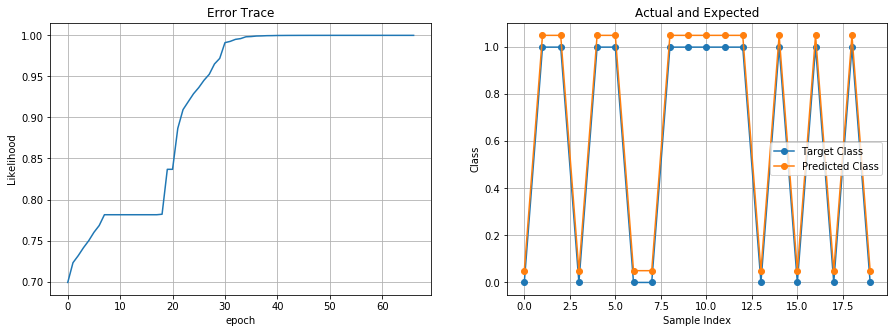

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Error Trace')
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Actual and Expected')
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);
plt.grid(True)

The plot on the left shows the log likelihool vs iteration which is the output of the training function.  It shows that the network needs about 35 intervals to reach the best behavior.  The plot on the right shows the actual data ('Target class') and the values predicted by the trained neural network ('Predicted Class').  Since the predicted values exatly match the expected values, a small offset was added so you could clearly see both sets of data. 

##### Create a NeuralNetworkClassifier object - PyTorch version

In [83]:
np.random.seed(42)  # Only used to commpare with lecture notes

nnet_new = NeuralNetworkClassifier(2, [10, 10], [0, 1], True)
nnet_new

NeuralNetworkClassifier(2, [10, 10], [0 1], use_torch=True)  Network is not trained.

In [84]:
T_std = nnet_new._standardizeT(T)
n_diff = (T_std != T).sum()
print(f'There are {n_diff} samples different')

There are 0 samples different


In [85]:
T_unstd = nnet_new._unstandardizeT(T)
n_diff = (T_unstd != T).sum()
print(f'There are {n_diff} samples different')

There are 0 samples different


The two code cells above (9 & 10) show that the '_standardizeT' and '_unstandardizeT' have no effect.  The output of each function is saved, then compareed with the input.  The total number of differences are printed and show that they are identical

In [86]:
# Create PyTorch version of the data for verification
Xt = torch.tensor(X, dtype=torch.float)  # 32 bit
Tt = torch.tensor(T, dtype=torch.float)

In [87]:
nnet_new._setup_standardize(Xt, Tt)
Xstt = nnet_new._standardizeX(Xt)
Xstt

tensor([[ 1.0560, -1.4397],
        [ 1.0560,  0.9598],
        [-1.2907, -1.4397],
        [ 1.0560, -0.2399],
        [ 1.0560,  0.9598],
        [ 1.0560,  0.9598],
        [-1.2907,  0.9598],
        [-0.1173, -1.4397],
        [-0.1173, -0.2399],
        [-0.1173, -0.2399],
        [-1.2907, -1.4397],
        [-0.1173, -0.2399],
        [-1.2907, -1.4397],
        [-1.2907,  0.9598],
        [ 1.0560,  0.9598],
        [-0.1173,  0.9598],
        [-0.1173, -0.2399],
        [ 1.0560, -0.2399],
        [ 1.0560,  0.9598],
        [-1.2907,  0.9598]])

In [88]:
Y, Z = nnet_new._forward_pass(Xstt)
Y

tensor([[0.5517, 0.4483],
        [0.5292, 0.4708],
        [0.5952, 0.4048],
        [0.5364, 0.4636],
        [0.5292, 0.4708],
        [0.5292, 0.4708],
        [0.5965, 0.4035],
        [0.5713, 0.4287],
        [0.5638, 0.4362],
        [0.5638, 0.4362],
        [0.5952, 0.4048],
        [0.5638, 0.4362],
        [0.5952, 0.4048],
        [0.5965, 0.4035],
        [0.5292, 0.4708],
        [0.5600, 0.4400],
        [0.5638, 0.4362],
        [0.5364, 0.4636],
        [0.5292, 0.4708],
        [0.5965, 0.4035]])

In [89]:
w = nnet_new._pack(nnet_new.Vs, nnet_new.W)
T_indicator_vars = np.hstack((1 - T, T))  # this only works for this particular two-class toy data
T_indicator_vars = torch.tensor(T_indicator_vars, dtype=torch.float)
nnet_new._objectiveF(w, Xt, T_indicator_vars)

tensor(0.3525)

In [90]:
nnet_new.train(X, T, 100)

NeuralNetworkClassifier(2, [10, 10], [0 1], use_torch=True)
   Network was trained for 100 epochs that took 1.7300 seconds. Final objective value is 1.000

In [91]:
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape

(torch.Size([20, 1]), (20, 2))

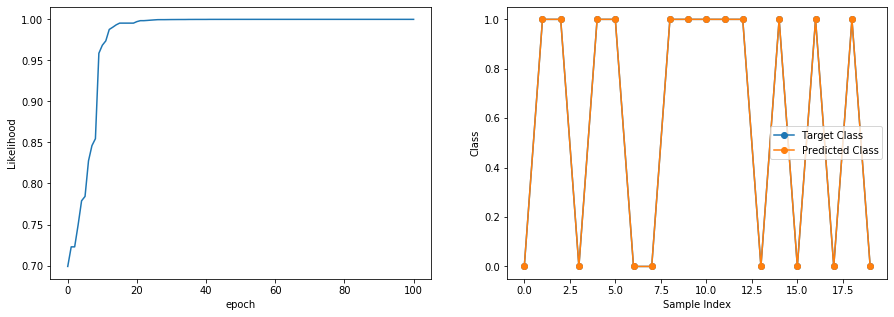

In [92]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

## Real Data Set

I am using the [Wine](https://archive.ics.uci.edu/ml/datasets/Wine) classification data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).  This data is the result of a chemical analysis of wines grown in the same region in Italy, but derived from three different cultivars.  There are thirteen data points for each sample, and the objective is to see if you can find which cultivar provided the wine based on this analysis.

The wines are resolved into one of three classes which represent the cultivars.  This is the 1st attribute of the data.  
- Number of instances  
  - class 1 59  
  - class 2 71  
  - class 3 48  
- TOTAL = 178

In [18]:
# Load data from the CSV file
data = np.loadtxt('wine.data', delimiter=",")

# NOTE: The data is ordered based on the resulting class.  For the initial experiment, 
#       I will leave it as is, just because I think the charts are easier to understand.
#       You can uncomment the following line to randomize the data if desired
#np.random.shuffle(data)

# The first column is the class
# Take all rows, first column
T = data[:,0].reshape(-1,1).astype(int)

# Get class list from the Target Data
class_list = list(np.unique(T))

# Data is everything except first column
# Take all rows, all but first colum
X = data[:,1:]

# Get the number of inputs from the data
num_inputs = X.shape[1]

# Print some usefull info
print(f'X.shape({X.shape}), T.shape({T.shape}))')

X.shape((178, 13)), T.shape((178, 1)))


## Experiments

### 'scg'

Try a different number of hidden layers and units in the hidden layers with the 'scg' algorithm.  The learning rate and momentum rate do not apply to this algorithm.

In [19]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs,           [], class_list, X, T, X, 30, 'scg', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs,         [50], class_list, X, T, X, 30, 'scg', 0.001, 0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [50, 20, 20], class_list, X, T, X, 30, 'scg', 0.001, 0.0)
n_correct_0 = (Y_class_test_0 == T).sum()
n_correct_1 = (Y_class_test_1 == T).sum()
n_correct_2 = (Y_class_test_2 == T).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(100.00)


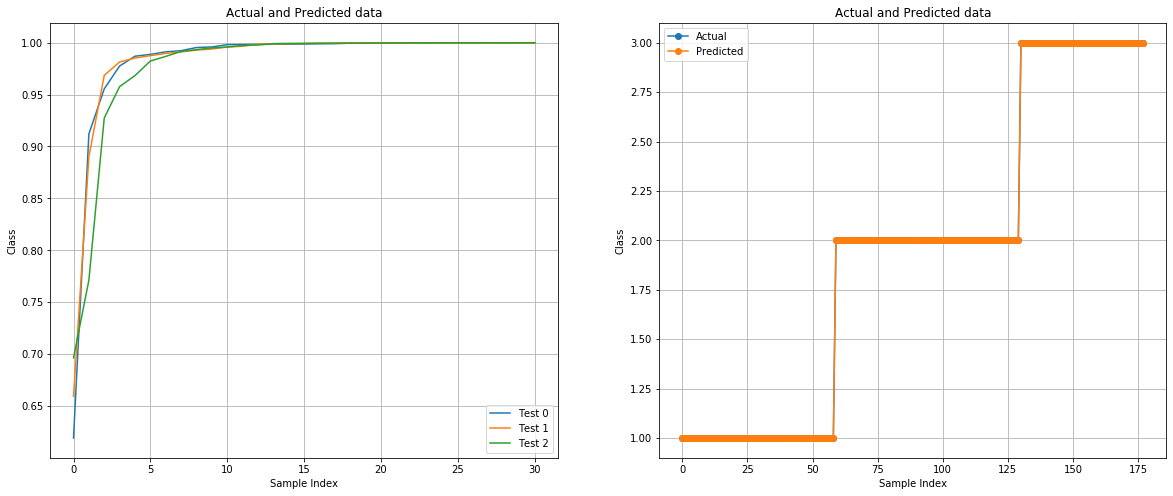

In [20]:
summary(net_test_0, net_test_1, net_test_2, T, Y_class_test_0, n_correct_0, n_correct_1, n_correct_2)

The network trains better with fewer hidden layers, but all configurations train within 15 iterations.  Once trained, all network correctly predict 100% of the datapoints.  The learning_rate and momentum_rate do not apply to this algorithm, so either of the first two configurations would be preferred.

### SGD

##### 'sgd' - hidden layers and units
Try a different number of hidden layers and units in the hidden layers with the 'sgd' algorithm and all other parameters fixed.

In [21]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs,        [], class_list, X, T, X, 50000, 'sgd', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs,      [50], class_list, X, T, X, 50000, 'sgd', 0.001, 0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [5, 5, 5], class_list, X, T, X, 50000, 'sgd', 0.001, 0.0)
n_correct_0 = (Y_class_test_0 == T).sum()
n_correct_1 = (Y_class_test_1 == T).sum()
n_correct_2 = (Y_class_test_2 == T).sum()

Percent correct: Test_0(99.44) Test_1(100.00) Test_2(98.31)


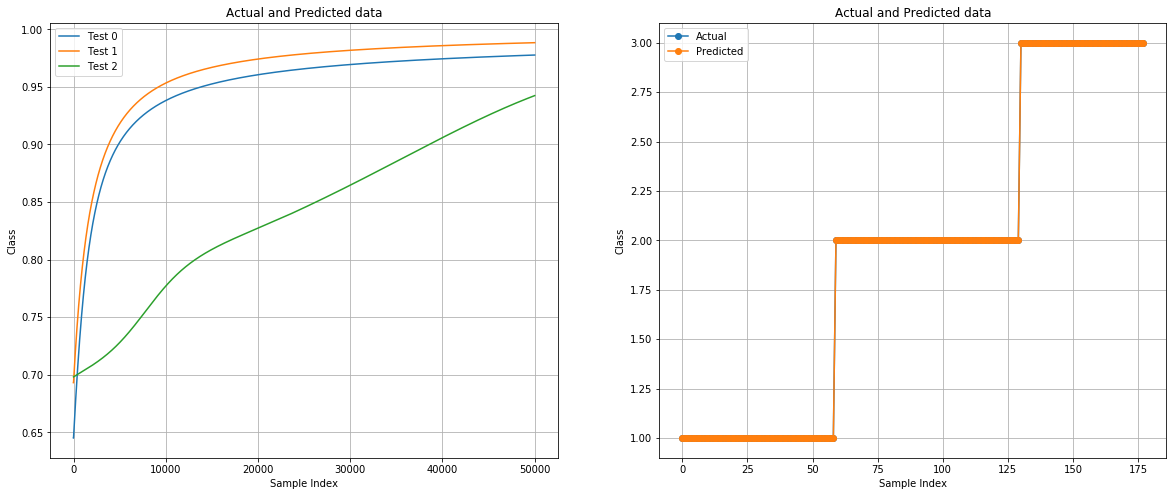

In [22]:
summary(net_test_0, net_test_1, net_test_2, T, Y_class_test_1, n_correct_0, n_correct_1, n_correct_2)

Networks with fewer hidden layers preform better than those with more hidden layers.  The best behavior is found with a single hidden layer, but it never fully trains even with a very large nuber of iterations.   With the best network, the network correctly predictss 100% of the datapoints.

##### 'sgd' - single hidden layer, variable number of units
Try a different number of units in a single hidden layer and all other parameters fixed.

In [23]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs,  [1], class_list, X, T, X, 50000, 'sgd', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs, [10], class_list, X, T, X, 50000, 'sgd', 0.001, 0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [50], class_list, X, T, X, 50000, 'sgd', 0.001, 0.0)
n_correct_0 = (Y_class_test_0 == T).sum()
n_correct_1 = (Y_class_test_1 == T).sum()
n_correct_2 = (Y_class_test_2 == T).sum()

Percent correct: Test_0(73.03) Test_1(100.00) Test_2(99.44)


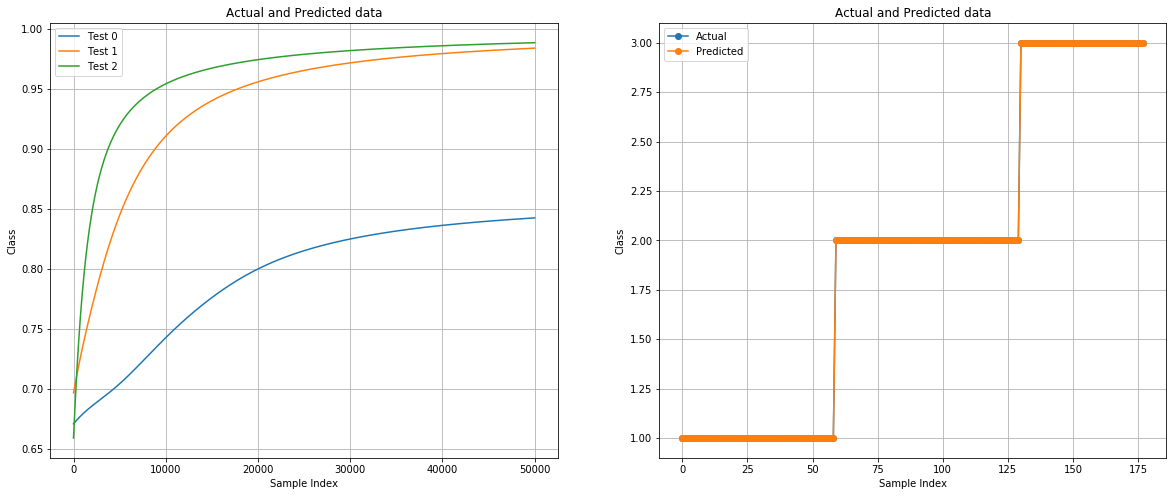

In [24]:
summary(net_test_0, net_test_1, net_test_2, T, Y_class_test_1, n_correct_0, n_correct_1, n_correct_2)

Networks with more units in the hidden laye preform better than those with fewer units.  The best network never fully trains even with a very large nuber of iterations. With the best network, the network correctly predictss 100% of the datapoints.

##### 'sgd' - single hidden layer, variable learning rate
Try a different learning rate with all other parameters fixed.

In [25]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs, [50], class_list, X, T, X, 50000, 'sgd', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs, [50], class_list, X, T, X, 50000, 'sgd', 0.01,  0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [50], class_list, X, T, X, 50000, 'sgd', 0.1,   0.0)
n_correct_0 = (Y_class_test_0 == T).sum()
n_correct_1 = (Y_class_test_1 == T).sum()
n_correct_2 = (Y_class_test_2 == T).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(99.44)


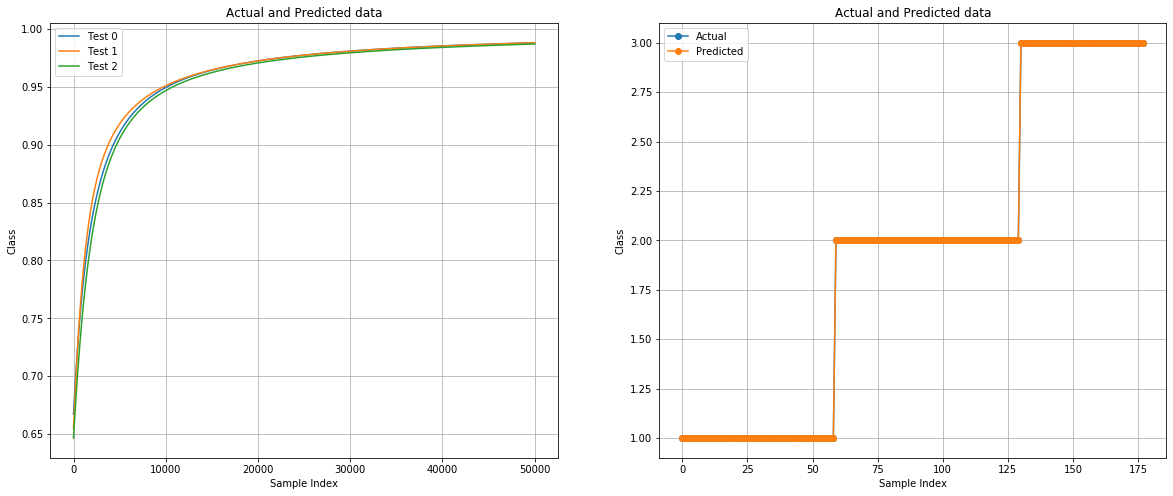

In [26]:
summary(net_test_0, net_test_1, net_test_2, T, Y_class_test_0, n_correct_0, n_correct_1, n_correct_2)

The learning rate has very little affet on the overall performance of the neural network.  All configurations never fully train even with a very large number of iterations. With the best network, the network correctly predictss 100% of the datapoints.

##### 'sgd' - single hidden layer, variable momentum rate
Try a different momentum rate with all other parameters fixed.

In [27]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs, [50], class_list, X, T, X, 50000, 'sgd', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs, [50], class_list, X, T, X, 50000, 'sgd', 0.001, 0.1)
net_test_2, Y_class_test_2 = run(num_inputs, [50], class_list, X, T, X, 50000, 'sgd', 0.001, 0.5)
n_correct_0 = (Y_class_test_0 == T).sum()
n_correct_1 = (Y_class_test_1 == T).sum()
n_correct_2 = (Y_class_test_2 == T).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(99.44)


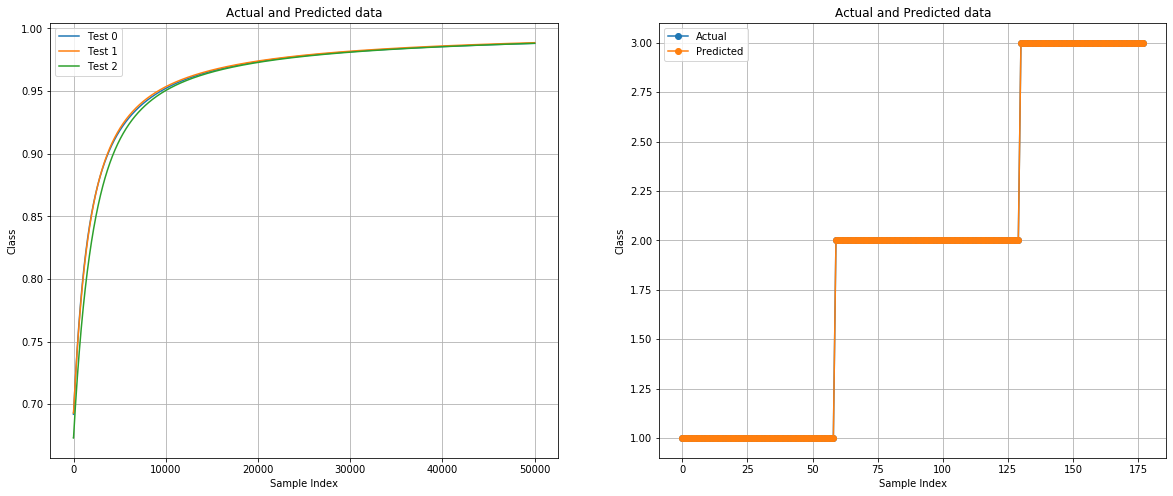

In [28]:
summary(net_test_0, net_test_1, net_test_2, T, Y_class_test_0, n_correct_0, n_correct_1, n_correct_2)

The momentum rate has very little affet on the overall performance of the neural network. All configurations never fully train even with a very large number of iterations. With the best network, the network correctly predictss 100% of the datapoints.

##### 'adam' - hidden layers and units
Try a different number of hidden layers and units in the hidden layers with the 'adam' algorithm and all other parameters fixed.

In [29]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs,        [], class_list, X, T, X, 10000, 'adam', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs,      [50], class_list, X, T, X, 10000, 'adam', 0.001, 0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [5, 5, 5], class_list, X, T, X, 10000, 'adam', 0.001, 0.0)
n_correct_0 = (Y_class_test_0 == T).sum()
n_correct_1 = (Y_class_test_1 == T).sum()
n_correct_2 = (Y_class_test_2 == T).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(100.00)


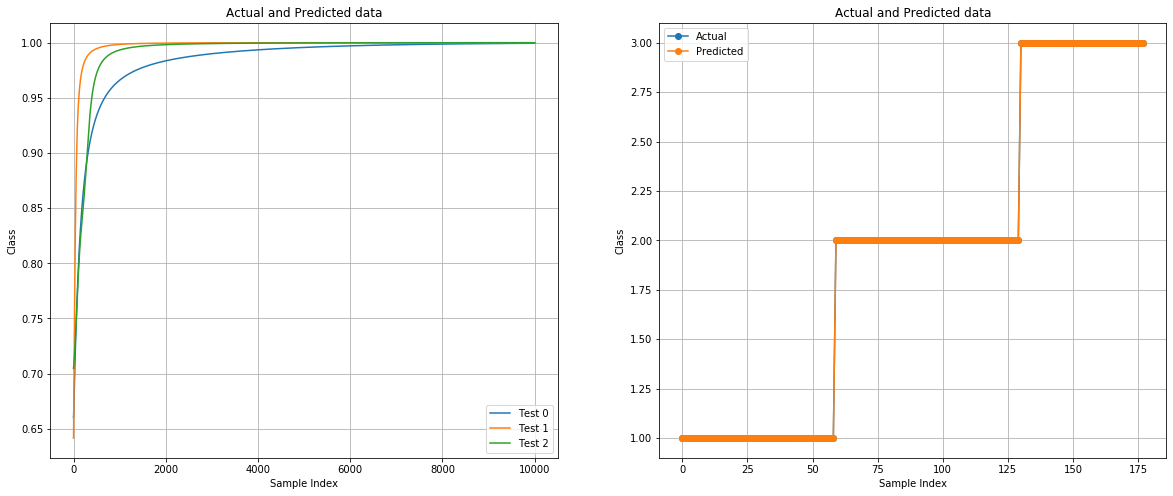

In [30]:
summary(net_test_0, net_test_1, net_test_2, T, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The network with a single hidden layer performs better than those with more or less, but all configurations train after about 8000 iterations. Once trained, the network correctly predictss 100% of the datapoints.

##### 'adam' - single hidden layer, variable momentum rate
Try a different momentum rate with all other parameters fixed.

In [31]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs,   [1], class_list, X, T, X, 10000, 'adam', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs,  [10], class_list, X, T, X, 10000, 'adam', 0.001, 0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [100], class_list, X, T, X, 10000, 'adam', 0.001, 0.0)
n_correct_0 = (Y_class_test_0 == T).sum()
n_correct_1 = (Y_class_test_1 == T).sum()
n_correct_2 = (Y_class_test_2 == T).sum()

Percent correct: Test_0(91.57) Test_1(100.00) Test_2(100.00)


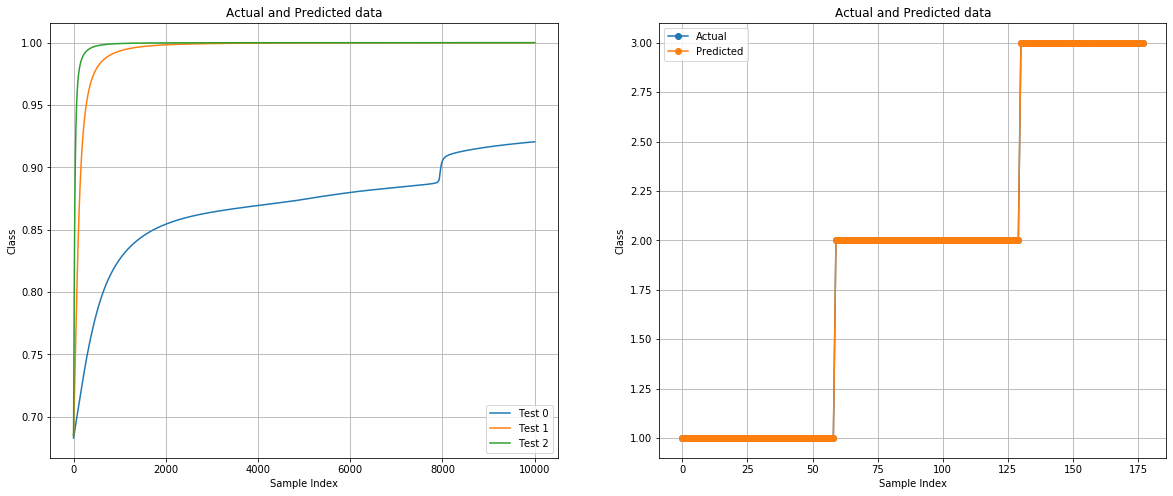

In [32]:
summary(net_test_0, net_test_1, net_test_2, T, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The network with the most units in the hidden layer performs better than those with less.  The single hidden layer significantly reducces the number of iterations needed to train the network; the network with no hidden layers doesn't train in 10000 cycles while those with a hidden layer train in 2000 or less.  Once trained, the best network correctly predictss 100% of the datapoints.

##### 'adam' - single hidden layer, variable learning rate
Try a different learning rate with all other parameters fixed.

In [33]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs, [100], class_list, X, T, X, 1000, 'adam', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs, [100], class_list, X, T, X, 1000, 'adam', 0.01,  0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [100], class_list, X, T, X, 1000, 'adam', 0.1,   0.0)
n_correct_0 = (Y_class_test_0 == T).sum()
n_correct_1 = (Y_class_test_1 == T).sum()
n_correct_2 = (Y_class_test_2 == T).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(100.00)


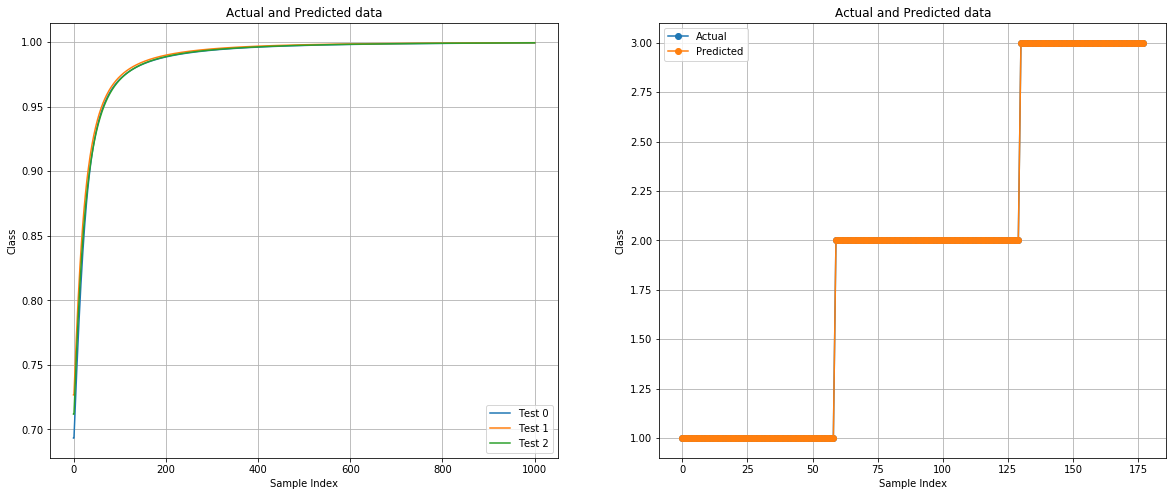

In [34]:
summary(net_test_0, net_test_1, net_test_2, T, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The learning rate has very little affet on the overall performance of the neural network. All configurations fully train around 600 iterations. All trained networks correctly predict 100% of the datapoints.

##### 'adam' - single hidden layer, variable momentum rate
Try a momentum learning rate with all other parameters fixed.

In [35]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs, [100], class_list, X, T, X, 1000, 'adam', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs, [100], class_list, X, T, X, 1000, 'adam', 0.001, 0.1)
net_test_2, Y_class_test_2 = run(num_inputs, [100], class_list, X, T, X, 1000, 'adam', 0.001, 0.5)
n_correct_0 = (Y_class_test_0 == T).sum()
n_correct_1 = (Y_class_test_1 == T).sum()
n_correct_2 = (Y_class_test_2 == T).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(100.00)


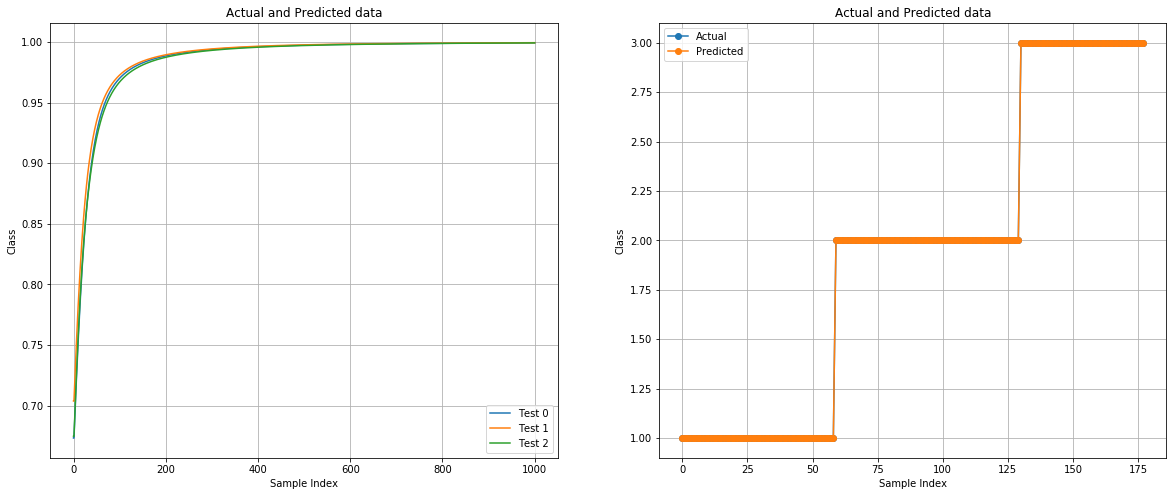

In [36]:
summary(net_test_0, net_test_1, net_test_2, T, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The momentum rate has very little affet on the overall performance of the neural network. All configurations fully train around 600 iterations. All trained networks correctly predict 100% of the datapoints.

### Summary

I was able to find several network configurations and training algorithms that yield good overall training results for the 'wine' data.  The 'scg' algorithm works best for training since all configurations tested fully train around 15 iterations. The 'adam' algorithm works fairly well since most configurations do fully train (1.000), but requires ~600 iterations to do so.  The 'sgd' algorithm has the worst training performance since no configuration results in full training despite the largest amount of iterations. In all cases, I did not see any statistical difference based on the learning_rate or momentum_rate.

Once the networks were trained, I was able to find several configurations that do a very good job at predicting the correct class.  This is somewhat expected given the fact that we are using all of the training data to test the network.  I am somewhat surprised that the network preformed so well given the limited number samples for each class. It will be interesting to see the Extra Credit results (below) to see how the network behaves with less training data and on test data it has not yet seen.

# Grading

Download [A3grader.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.zip) and extract A3grader.py from it. Run the code in the following cell to demonstrate an example grading session. You should see a perfect execution score of 80/80 if your functions are defined correctly. Other tests will be performed on your checked in notebook to make up the 80 execution points. The remaining 20 points will be based on the results you obtain from the classification data you download and your discussion of the results.

In [37]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Staab-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing if your NeuralNetworkClassifier can learn to detect vowels when given
their ascii codes.

import numpy as np
ascii_code = list(range(65, 91)) + list(range(97, 123))
chars = [chr(n).lower() for n in ascii_code]
vowel = [c in ['a', 'e', 'i', 'o', 'u'] for c in chars]
X = np.array(ascii_code).reshape((-1, 1))
T = np.array(vowel).reshape((-1, 1))
classes = np.unique(T)

np.random.seed(120)
nnet = NeuralNetworkClassifier(X.shape[1], [50, 20, 20], classes)
nnet.train(X, T, 10000, verbose=True)
Yc, Y = nnet.use(X)
n_correct = (Yc == T).sum()
print(f'{n_correct} out of {T.shape[0]} samples, or {n_correct/T.shape[0]*100:.2f} percent.')
SCG: Iteration 1000 ObjectiveF=0.79863 Scale=1.000e-15 Seconds=1.260
SCG: Iteration 2000 ObjectiveF=0.80751 Scale=1.00

<Figure size 432x288 with 0 Axes>

# Extra Credit

1. For the data set you have downloaded, randomly partition the data into about 80% for training and 20% for testing.  Discuss the percent of samples correctly classified for train and test partitions and how variations in netowrk size, epochs, and optimization algorithm effect the results.

In [38]:
# Reload data from the CSV file
data = np.loadtxt('wine.data', delimiter=",")

# NOTE: The data is ordered based on the resulting class.  Since we are using a subset for training
#       and test, we need an random distrubution of the data.  The simplest way to get this is to 
#       randomly shuffle the rows, which is what I'm doing in the next step
np.random.shuffle(data)

# The first column is the class - Take all rows, first column
T_shfl = data[:,0].reshape(-1,1).astype(int)

# Get class list from the Target Data
class_list_shfl = list(np.unique(T_shfl))

# Data is everything except first column - Take all rows, all but first colum
X_shfl = data[:,1:]

# Get the number of inputs from the data
num_inputs = X_shfl.shape[1]

data_len = X_shfl.shape[0]
num_train = int(data_len * 0.8)
num_test = data_len - num_train
X_train = X_shfl[0:num_train, :]
T_train = T_shfl[0:num_train, :]
X_test  = X_shfl[num_train:, :]
T_test = T_shfl[num_train:, :]

# Print some usefull info
print(f'Total number of samples ({data_len}) num_train({num_train}) num_test({num_test})')

Total number of samples (178) num_train(142) num_test(36)


### Experiments

### 'scg'
Try a different number of hidden layers and units in the hidden layers with the 'scg' algorithm and all other parameters fixed


In [39]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs,          [],  class_list, X_train, T_train, X_test, 500, 'scg', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs,        [50],  class_list, X_train, T_train, X_test, 500, 'scg', 0.001, 0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [50, 20, 20], class_list, X_train, T_train, X_test, 500, 'scg', 0.001, 0.0)
n_correct_0 = (Y_class_test_0 == T_test).sum()
n_correct_1 = (Y_class_test_1 == T_test).sum()
n_correct_2 = (Y_class_test_2 == T_test).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(100.00)


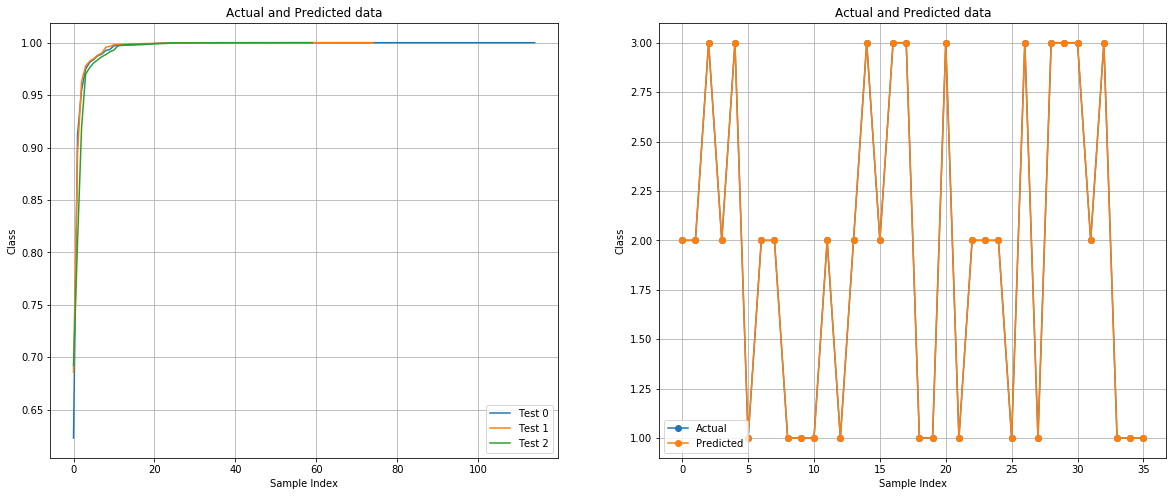

In [40]:
summary(net_test_0, net_test_1, net_test_2, T_test, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The network behaves the same as the previous experiment using all data for training.  It performs better with fewer hidden layers and all train within 20 iterations.  Using all data, the network trained in 15 iterations, so more data samples reduces the amount of time to train.  Once trained, the network correctly predictss 100% of the datapoints. The learning_rate and momentum_rate do not apply to this algorithm, so either of the first two configurations would be preferred.

### 'sgd'
Try a different number of hidden layers and units the hidden layers with the 'sgd' algorithm and all other parameters fixed

In [41]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs,        [], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs,      [50], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.001, 0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [5, 5, 5], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.001, 0.0)
n_correct_0 = (Y_class_test_0 == T_test).sum()
n_correct_1 = (Y_class_test_1 == T_test).sum()
n_correct_2 = (Y_class_test_2 == T_test).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(97.22)


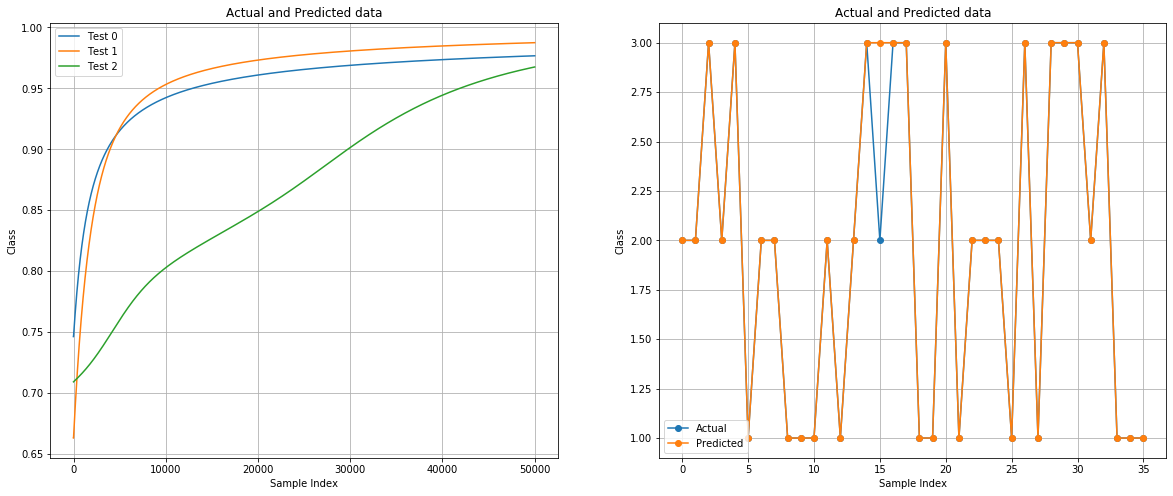

In [42]:
summary(net_test_0, net_test_1, net_test_2, T_test, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The network behaves the same as the previous experiment using all data for training.  Networks with fewer hidden layers preform better than those with more hidden layers. The best behavior is found with a single hidden layer, but it never fully trains even with a very large nuber of iterations. With the best network, the network correctly predictss 100% of the datapoints.  Overall, less data does not seem to have a noticable impact.

##### 'sgd' - single hidden layer, variable number of units
Try a different number of units in a single hidden layer.

In [43]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs,  [1], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs, [10], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.001, 0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [50], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.001, 0.0)
n_correct_0 = (Y_class_test_0 == T_test).sum()
n_correct_1 = (Y_class_test_1 == T_test).sum()
n_correct_2 = (Y_class_test_2 == T_test).sum()

Percent correct: Test_0(61.11) Test_1(100.00) Test_2(100.00)


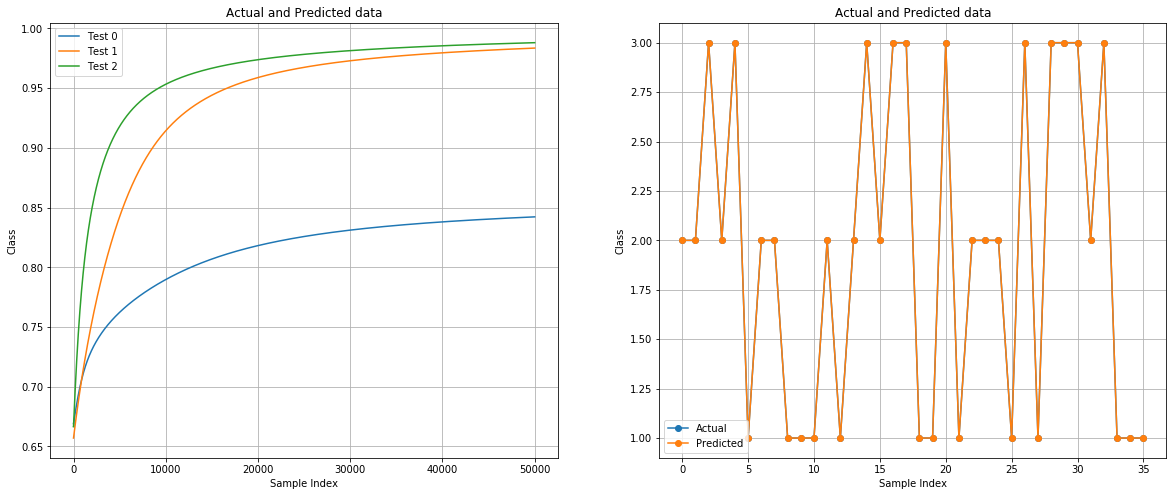

In [44]:
summary(net_test_0, net_test_1, net_test_2, T_test, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The network behaves the same as the previous experiment using all data for training.  Networks with more units in the hidden laye preform better than those with fewer units. The best network never fully trains even with a very large nuber of iterations. With the best network, the network correctly predictss 100% of the datapoints.   Overall, less data does not seem to have a noticable impact.

##### 'sgd' - single hidden layer, variable learning rate
Try a different learning rate with all other parameters fixed.

In [45]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs, [50], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs, [50], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.01,  0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [50], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.1,   0.0)
n_correct_0 = (Y_class_test_0 == T_test).sum()
n_correct_1 = (Y_class_test_1 == T_test).sum()
n_correct_2 = (Y_class_test_2 == T_test).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(100.00)


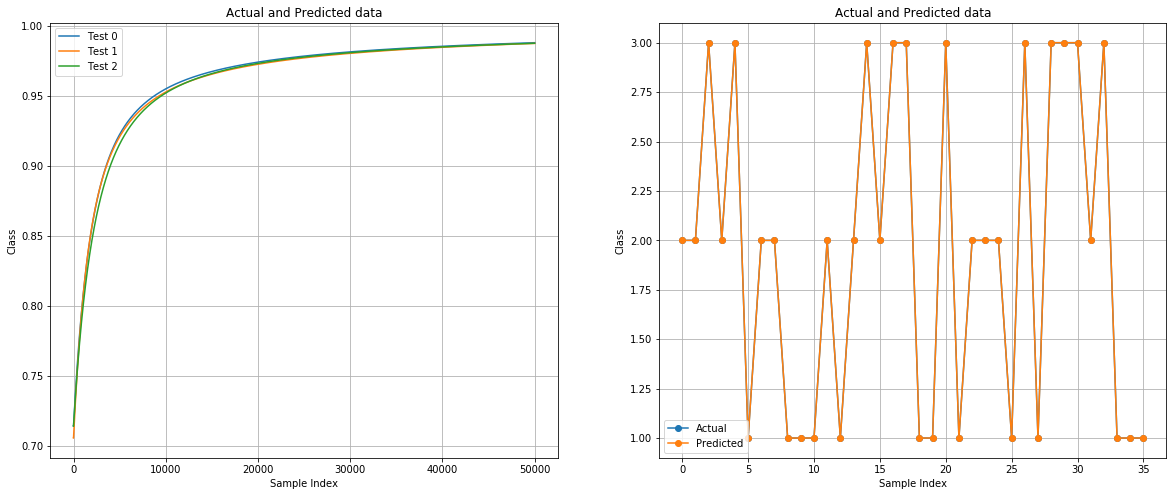

In [46]:
summary(net_test_0, net_test_1, net_test_2, T_test, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The network behaves the same as the previous experiment using all data for training.  The learning rate has very little affet on the overall performance of the neural network. All configurations never fully train even with a very large nuber of iterations. With the best network, the network correctly predictss 100% of the datapoints.  Overall, less data does not seem to have a noticable impact.

##### 'sgd' - single hidden layer, variable momentum rate
Try a different momentum rate with all other parameters fixed.

In [47]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs,        [], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs,      [50], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.001, 0.1)
net_test_2, Y_class_test_2 = run(num_inputs, [5, 5, 5], class_list, X_train, T_train, X_test, 50000, 'sgd', 0.001, 0.5)
n_correct_0 = (Y_class_test_0 == T_test).sum()
n_correct_1 = (Y_class_test_1 == T_test).sum()
n_correct_2 = (Y_class_test_2 == T_test).sum()

Percent correct: Test_0(97.22) Test_1(100.00) Test_2(100.00)


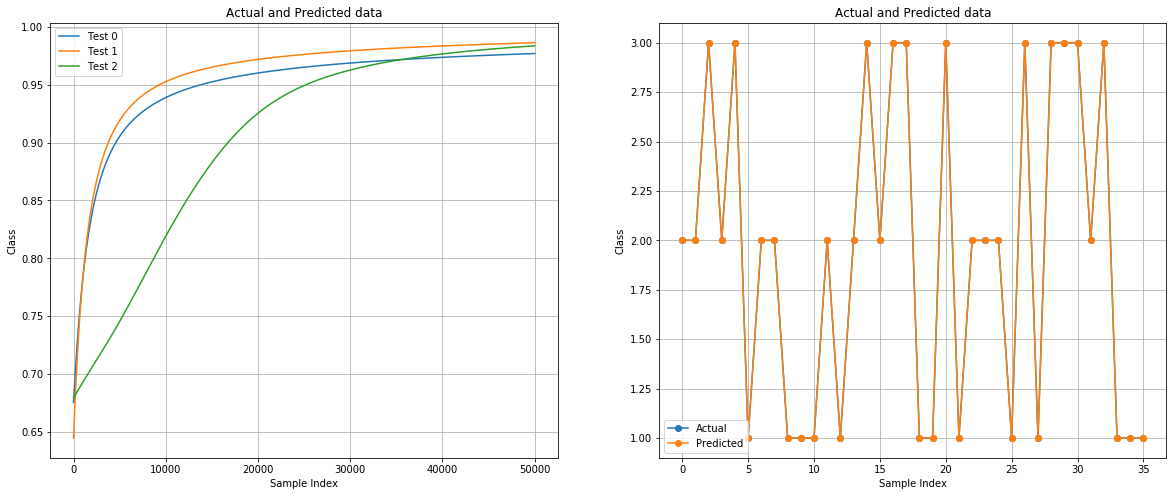

In [48]:
summary(net_test_0, net_test_1, net_test_2, T_test, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

This network behave simlarly to the previous experiment using all data for training.  One observation that is different is that the training does better for a single hidden layer comparted to the other configurations.  This is contrast to the the original experiment where all networks had nearly identical curves.  The training for all are above 0.95 but are a little more spread than than before.  Even with this difference, the best network correctly predictss 100% of the datapoints. Overall, less data does seem to have a noticable impact.

##### 'adam' - hidden layers and units
Try a different number of hidden layers and units the hidden layers with the 'adam' algorithm and all other parameters fixed

In [49]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs,        [], class_list, X_train, T_train, X_test, 10000, 'adam', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs,      [50], class_list, X_train, T_train, X_test, 10000, 'adam', 0.001, 0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [5, 5, 5], class_list, X_train, T_train, X_test, 10000, 'adam', 0.001, 0.0)
n_correct_0 = (Y_class_test_0 == T_test).sum()
n_correct_1 = (Y_class_test_1 == T_test).sum()
n_correct_2 = (Y_class_test_2 == T_test).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(100.00)


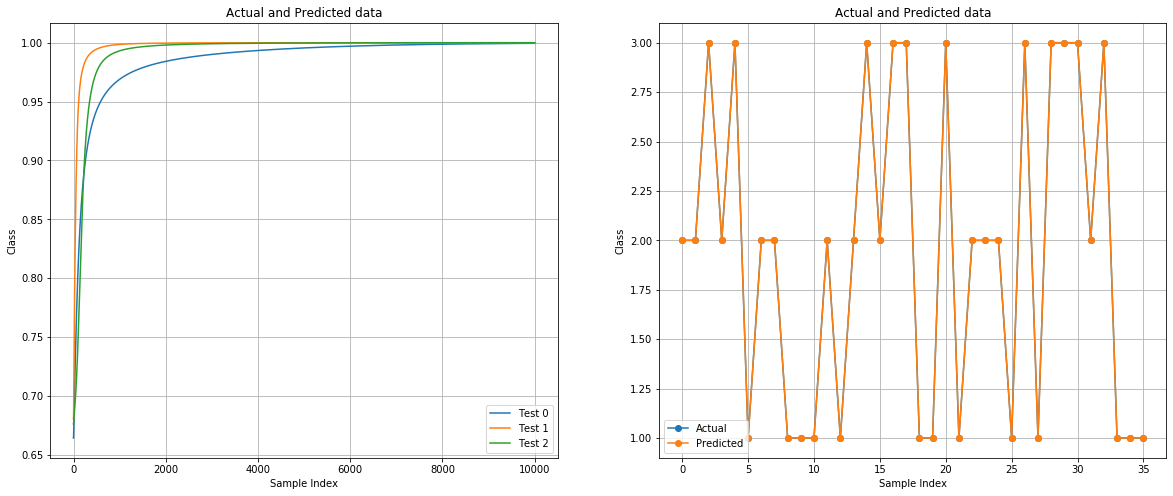

In [50]:
summary(net_test_0, net_test_1, net_test_2, T_test, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The network behaves the same as the previous experiment using all data for training.  The network with a single hidden layer performs better than those with more or less, but all configurations train after about 8000 iterations. Once trained, the network correctly predictss 100% of the datapoints.  Overall, less data does not seem to have a noticable impact.

##### 'adam' - single hidden layer, variable momentum rate
Try a different momentum rate with all other parameters fixed.

In [51]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs,   [1], class_list, X_train, T_train, X_test, 10000, 'adam', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs,  [10], class_list, X_train, T_train, X_test, 10000, 'adam', 0.001, 0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [100], class_list, X_train, T_train, X_test, 10000, 'adam', 0.001, 0.0)
n_correct_0 = (Y_class_test_0 == T_test).sum()
n_correct_1 = (Y_class_test_1 == T_test).sum()
n_correct_2 = (Y_class_test_2 == T_test).sum()

Percent correct: Test_0(88.89) Test_1(100.00) Test_2(100.00)


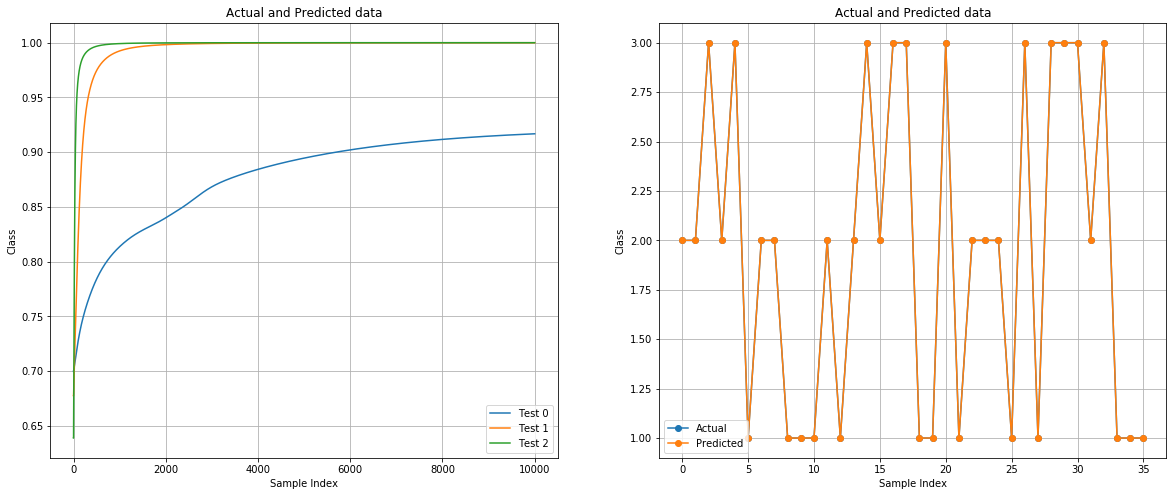

In [52]:
summary(net_test_0, net_test_1, net_test_2, T_test, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The network behaves the same as the previous experiment using all data for training.  The network with the most units in the hidden layer performs better than those with less. The increased units significantly reducces the number of iterations needed to train the network (~8000 to ~500). Once trained, the network correctly predictss 100% of the datapoints.  Overall, less data does not seem to have a noticable impact.

##### 'adam' - single hidden layer, variable learning rate
Try a different learning rate with all other parameters fixed

In [53]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs, [100], class_list, X_train, T_train, X_test, 1000, 'adam', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs, [100], class_list, X_train, T_train, X_test, 1000, 'adam', 0.01,  0.0)
net_test_2, Y_class_test_2 = run(num_inputs, [100], class_list, X_train, T_train, X_test, 1000, 'adam', 0.1,   0.0)
n_correct_0 = (Y_class_test_0 == T_test).sum()
n_correct_1 = (Y_class_test_1 == T_test).sum()
n_correct_2 = (Y_class_test_2 == T_test).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(100.00)


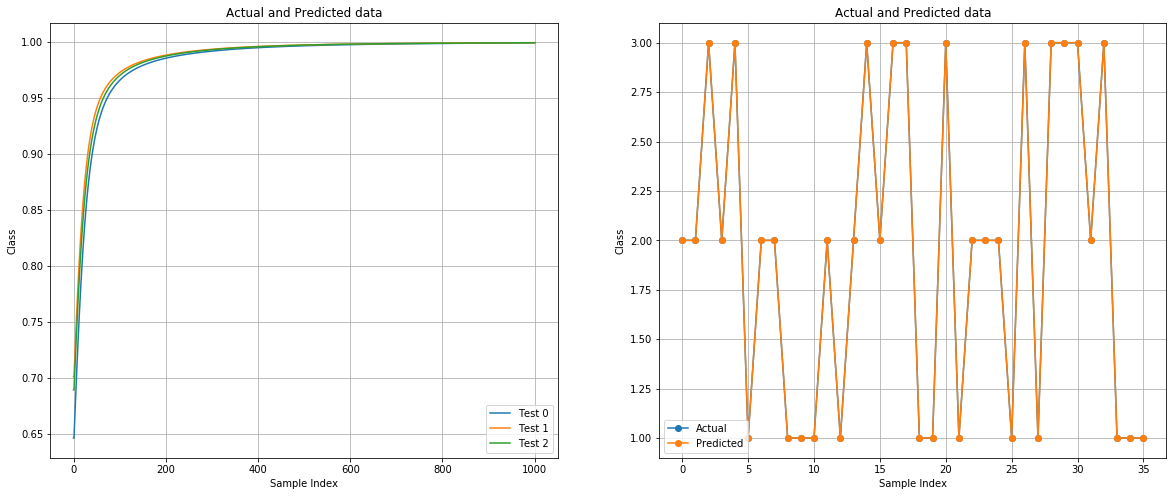

In [54]:
summary(net_test_0, net_test_1, net_test_2, T_test, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The network behaves the same as the previous experiment using all data for training.  The learning rate has very little affet on the overall performance of the neural network. All configurations fully train around 600 iterations. All trained networks correctly predict 100% of the datapoints.  Overall, less data does not seem to have a noticable impact.

##### 'adam' - single hidden layer, variable momentum rate
Try a momentum learning rate with all other parameters fixed.

In [55]:
%%capture
net_test_0, Y_class_test_0 = run(num_inputs, [100], class_list, X_train, T_train, X_test, 1000, 'adam', 0.001, 0.0)
net_test_1, Y_class_test_1 = run(num_inputs, [100], class_list, X_train, T_train, X_test, 1000, 'adam', 0.001, 0.1)
net_test_2, Y_class_test_2 = run(num_inputs, [100], class_list, X_train, T_train, X_test, 1000, 'adam', 0.001, 0.5)
n_correct_0 = (Y_class_test_0 == T_test).sum()
n_correct_1 = (Y_class_test_1 == T_test).sum()
n_correct_2 = (Y_class_test_2 == T_test).sum()

Percent correct: Test_0(100.00) Test_1(100.00) Test_2(100.00)


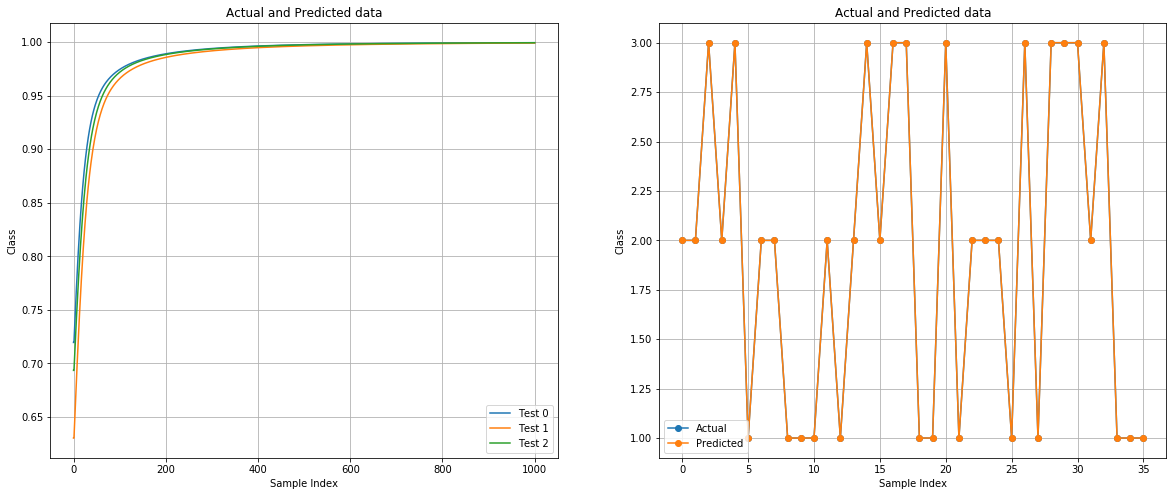

In [56]:
summary(net_test_0, net_test_1, net_test_2, T_test, Y_class_test_2, n_correct_0, n_correct_1, n_correct_2)

The network behaves the same as the previous experiment using all data for training.  The momentum rate has very little affet on the overall performance of the neural network. All configurations fully train around 600 iterations. All trained networks correctly predict 100% of the datapoints.  Overall, less data does not seem to have a noticable impact.

### Summary

I was able to find several network configurations and training algorithms that yield good overall results for the reduced data experiment. The results were very similar to the original experiment (more training data) where 'scg' performed best, followed by 'adam' then 'sgd'.  The one difference found was that the 'sgd' algorithm seemed to show more variance with less data, but even then, I still found a network with 100% accuracy.  My biggest take away is that the thirteen data points for each entry must have contained enough information to compensate for the reduced amount of data.  It's not yet clear to me which of the thirteen factors are most important, but a potential future experiment would be to manipulate the data and see which factors/combination of factors are most important.